In [1]:
%matplotlib inline
from __future__ import absolute_import, division, print_function, unicode_literals
import backtrader as bt
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import matplotlib.pyplot as plt

In [5]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
        ('printlog', False),
        ('datetime', 0),
        ('open', 1),
        ('high', 2),
        ('low', 3),
        ('close', 4),
        ('volume', -1),
    )
    
    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.maperiod)
        
        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25, subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        elif order.status in [order.Completed]:
            if order.isbuy():  # Buy
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %(
                        order.executed.price,
                        order.executed.value,
                        order.executed.comm
                    )
                )
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log(
                    'SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %(
                        order.executed.price,
                        order.executed.value,
                        order.executed.comm
                    )
                )
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %(trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            # Not yet ... we MIGHT BUY if ...
            # current close less than previous close and
            if self.dataclose[0] < self.sma[0]:
                # BUY, BUY, BUY!!! (with default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:
            # Already in the market ... we might sell
            if self.dataclose[0] > self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
                
    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f'%(self.params.maperiod, self.broker.getvalue()), doprint=True)

Starting Portfolio Value: 100000.00
2012-12-28, (MA Period 15) Ending Value 100883.00
Final Portfolio Value: 100883.00


<IPython.core.display.Javascript object>


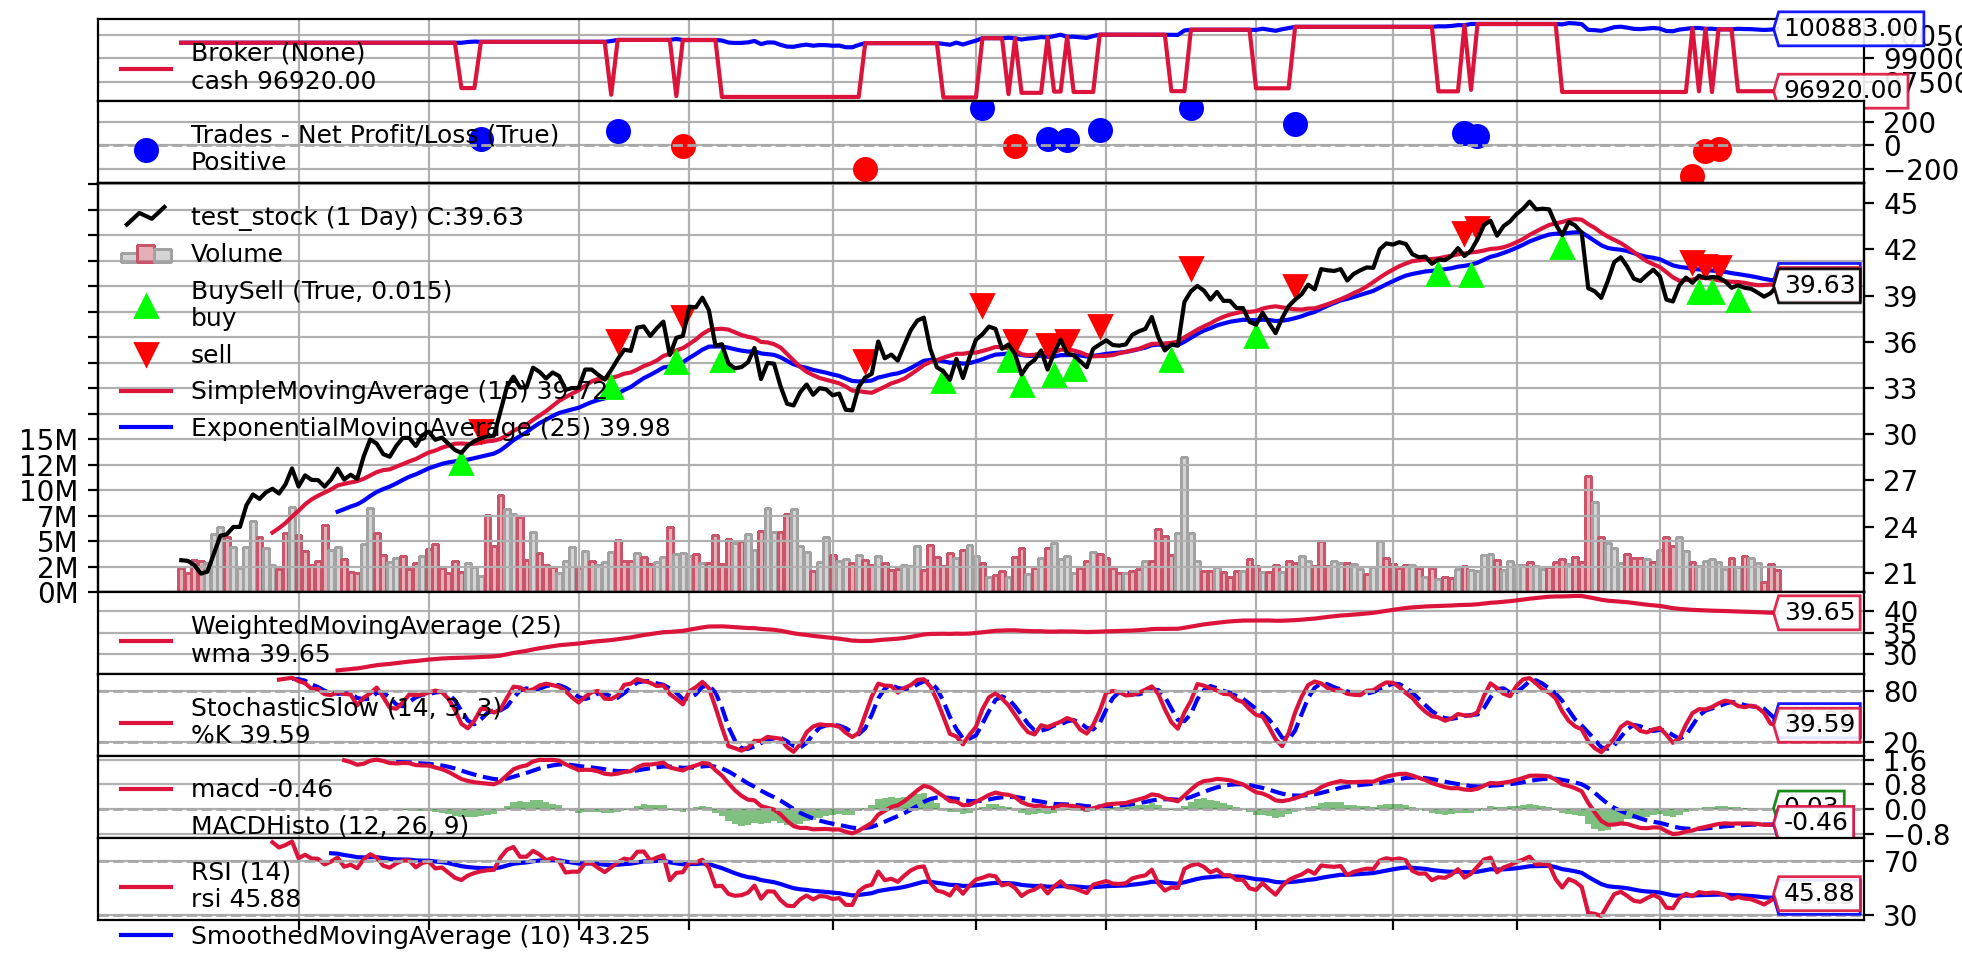

In [6]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    # modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    modpath = '../backtrader'
    datapath = os.path.join(modpath, './datas/orcl-1995-2014.txt')
    datapath = './data/test_stock.txt'

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2012, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2012, 12, 31),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100_000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    # Plot the result
    cerebro.plot()

In [8]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    # Add a strategy
    strats = cerebro.optstrategy(TestStrategy, maperiod=range(10, 31))

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    # modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    modpath = '../backtrader/'
    datapath = os.path.join(modpath, './datas/orcl-1995-2014.txt')
    datapath = './data/test_stock.txt'

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2012, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2012, 12, 31),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)
    
    # Set our desired cash start
    cerebro.broker.setcash(100_000.0)
    
    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)
    
    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.00)
    
    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run(maxcpus=1)
    
    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2012-12-28, (MA Period 10) Ending Value 101202.00
2012-12-28, (MA Period 11) Ending Value 100906.00
2012-12-28, (MA Period 12) Ending Value 101008.00
2012-12-28, (MA Period 13) Ending Value 100956.00
2012-12-28, (MA Period 14) Ending Value 100880.00
2012-12-28, (MA Period 15) Ending Value 100883.00
2012-12-28, (MA Period 16) Ending Value 100926.00
2012-12-28, (MA Period 17) Ending Value 101045.00
2012-12-28, (MA Period 18) Ending Value 100975.00
2012-12-28, (MA Period 19) Ending Value 100775.00
2012-12-28, (MA Period 20) Ending Value 100838.00
2012-12-28, (MA Period 21) Ending Value 100717.00
2012-12-28, (MA Period 22) Ending Value 100446.00
2012-12-28, (MA Period 23) Ending Value 100528.00
2012-12-28, (MA Period 24) Ending Value 100598.00
2012-12-28, (MA Period 25) Ending Value 100590.00
2012-12-28, (MA Period 26) Ending Value 100765.00
2012-12-28, (MA Period 27) Ending Value 100765.00
2012-12-28, (MA Period 28) Ending Value 100765.00
2012-12-28, (M